<a href="https://colab.research.google.com/github/taesangeom/SK-T-Academy/blob/main/DL/AutoEncoder/1_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 저해상도 --> 고해상도 복원
# ref : https://arxiv.org/pdf/1603.09056

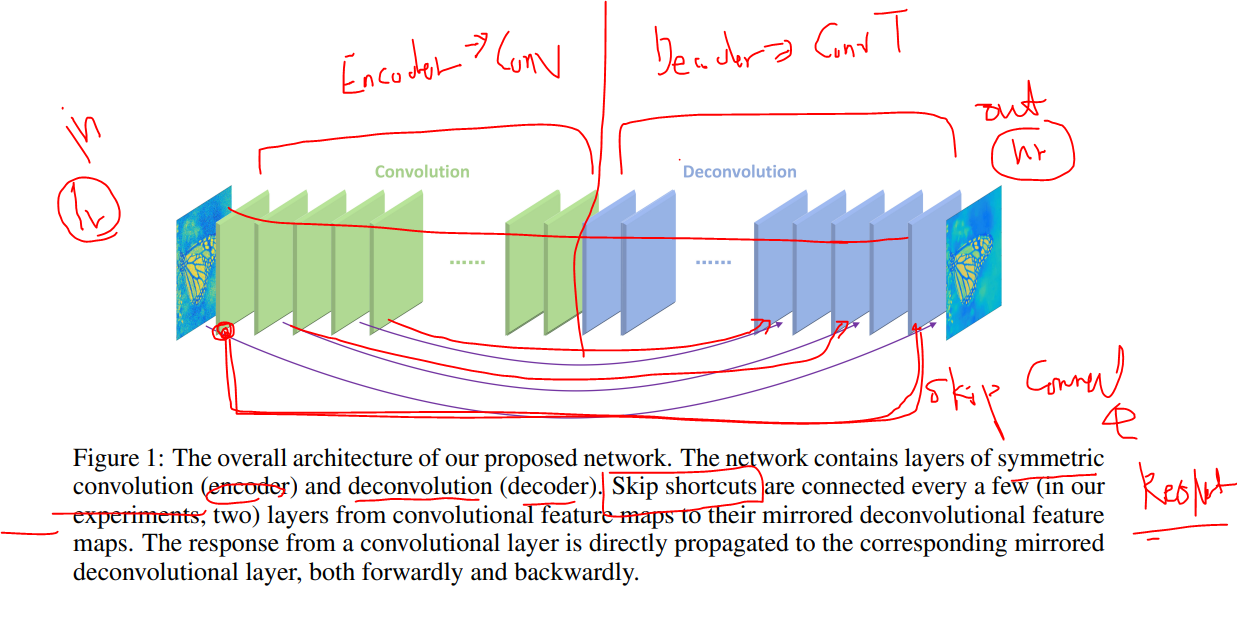

In [ ]:
# 기본적인 구조 1 : VGG을 이용을 해서 이미지의 특징을 추출!!!!
# ==> Encoder 부분으로 활용하겠다!!!!
# 기본적인 구조 2 : AE 대칭 구조를 사용을 해서 디코더쪽을!!!!!
# 기본적인 구조 3 : 중간에 인코더쪽에서 추출하는 특징에 대한 정보..
#                   복원할 때 대칭적인 위치에서 정보를 같이 보상처리!!!
#                  : 치팅 페이퍼!!!!! ---> resnet
# ==> 이미 잘 알려진 구조들을 잘 원하는 목적에 맞게 잘 조립했다!!!!

<img src="https://drive.google.com/uc?id=1YF1fZv2aEYkZKBHC4RXGtKeHBGe9dKEH">

In [ ]:
# ==> 참고 : 이미지 복원쪽에서 PSNR지표 loss
# --> 픽셀에 대한 값의 일치도를 기준으로 잡은 loss function/평가지표!!!
#     좋은 지표의 방향성은 : 값이 커지는 것이 좋은 모델이라고 평가!!!!!
#     : 논문/ 수치적인 다른 논문과 비교
#     : 약간 눈으로 잘 되는 것들에 대한 보여주기!!!!
# 참고) 어떤 부분에 포커스를 하느냐에 따라서 평가 지표는 달라짐!!!!

In [ ]:
# 목적 : 저해상도의 이미지를 고해상도로 복원을 하고 싶다!!!!!
# 1. 입력 데이터 셋을 구축!!!!!
#    입력 : 저해상도 이미지
#    출력 : 고행상도 이미지
# 2. 몇 개의 층을 중심으로 네트워크를 설계할지!!!!
#    : 네트워크 설계를 함수로
#    : 구조가 정확하게 대칭인 부분을 어떻게 할지!!!

In [ ]:
import tensorflow as tf
import numpy

In [ ]:
# 일반 이미지 데이터셋으로 lr -- hr데이터 쌍을 생성!!
# colab에서 다음 경로에서 다운로드
!gdown 1N2qIHmXanRNc4UZN3L9vArfD0wV4yH_6

Downloading...
From (original): https://drive.google.com/uc?id=1N2qIHmXanRNc4UZN3L9vArfD0wV4yH_6
From (redirected): https://drive.google.com/uc?id=1N2qIHmXanRNc4UZN3L9vArfD0wV4yH_6&confirm=t&uuid=1897a6aa-dc7d-49fa-97cf-87891dc4d67d
To: /content/bsd500_images.zip
100% 37.5M/37.5M [00:00<00:00, 97.5MB/s]


In [ ]:
# zip 파일을 풀려고 함!!!!
# --> --q   --d
!unzip /content/bsd500_images.zip

Archive:  /content/bsd500_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: images/test/112056.jpg  
  inflating: images/test/112090.jpg  
  in

In [ ]:
# 필요한 파일 접근을 위해서
import os
import glob
# ==> 파이썬을 활용해서 os/파일에 접근을 하기 위해서..

In [ ]:
# 모든 학습 이미지 데이터 들에 대해서 접근!!!!
all_images_path = glob.glob( '/content/images/*/*.jpg')
print(len(all_images_path))

500


In [ ]:
print(all_images_path[:3])

['/content/images/test/385022.jpg', '/content/images/test/15011.jpg', '/content/images/test/106047.jpg']


In [ ]:
print(all_images_path[-3:])

['/content/images/val/302008.jpg', '/content/images/val/89072.jpg', '/content/images/val/14037.jpg']


In [ ]:
# 이미지에 대해서 확인!!!!!!
import PIL.Image as Image
import matplotlib.pyplot as plt

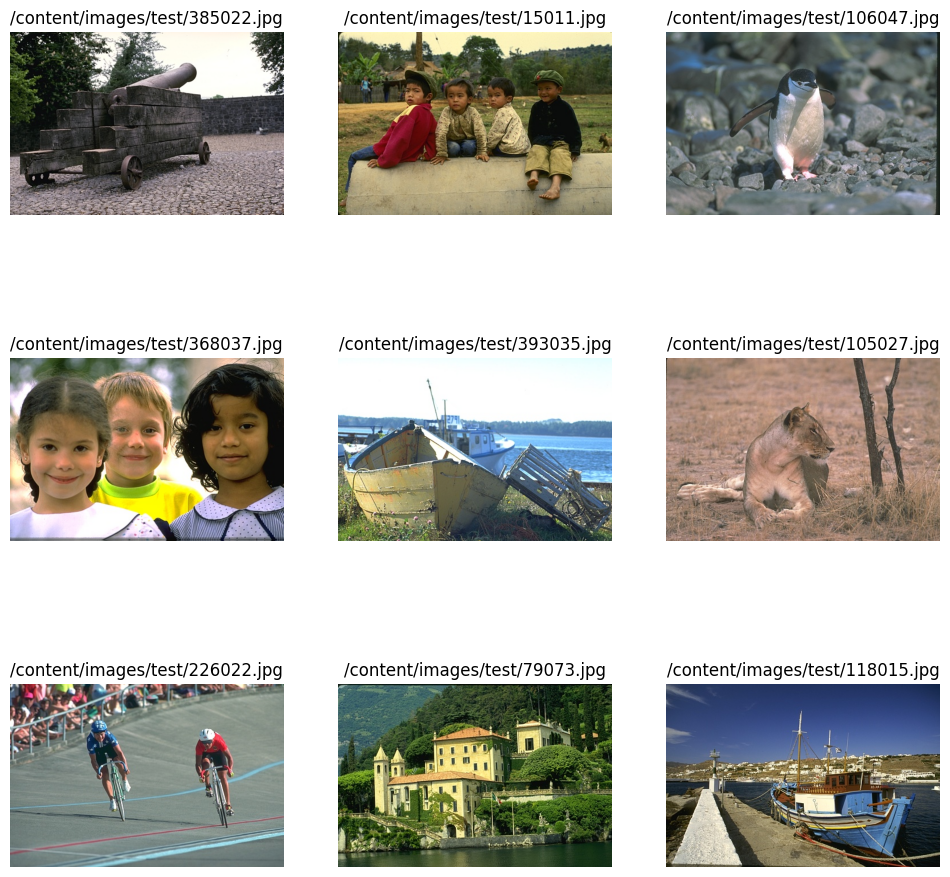

In [ ]:
plt.figure( figsize=(12,12))

for c in range(9): # 3 by 3 subplots
    plt.subplot(3,3,c+1)
    plt.imshow( plt.imread(all_images_path[c] ))
    plt.title(all_images_path[c])
    plt.axis("off")
plt.show()

In [ ]:
# 위의 보이는 이미지 데이터를 활용을 해서,,,,
# 저해상도 이미지 --- 고해상도 이미지

# 할 일 : 원본 이미지에서 일부분을 짤라서 저해상도-고해상도
#       ( Why 짤라서 : 이미지가 너무 커요....*** )
#                    : 다양한 특성에 대해서 학습
# 입력 : 이미지 경로 1장 기준
# 출력 : 그 이미지에서 일정 영역에 대한 저해상도-고해상도

def get_hr_and_lr( image_path):
    # 저는 잘 사용을 하지는 않지만,,,,TF에서도 이미지 처리 모듈
    # 간단히 소개를 하겠습니다...
    img = tf.io.read_file( image_path ) # 파일 불러오는 것
    img = tf.image.decode_jpeg( img, channels=3) # 이미지 데이터 채널을 3으로 명시!!!
    img = tf.image.convert_image_dtype( img, tf.float32) # 이미지 데이터를 tf의 float32형식 값으로 변환!!
    # ---> tf에서도 이미지 처리하는 기본적인 메서드!!!!

    # 1장 이미지에서 random 하게 작은 영역을 잘라내자.
    # --> 이유 : 시간관계상..
    hr = tf.image.random_crop( img, [50,50,3])
    # 어디서, 어떤 크기로 잘라줄까!!!!!!
    # --> 원본을 hr

    # 저해상도 이미지를 만드는 방법 중 심플한 경우가
    # 원본을 1/2 을 줄이고, 다시 복원을 하면,,
    lr = tf.image.resize( hr, [25,25]) # 원본hr을 50 x 50 --> 25 x 25
    lr = tf.image.resize(lr, [50,50]) # 25 x 25 --> 50 x 50

    # 네트워크 학습에 필요한 데이터 셋을!!!!
    # 출력 2개 : 순서 저해상도, 고해상도 (크기는 동일 50x50X3)
    return lr, hr

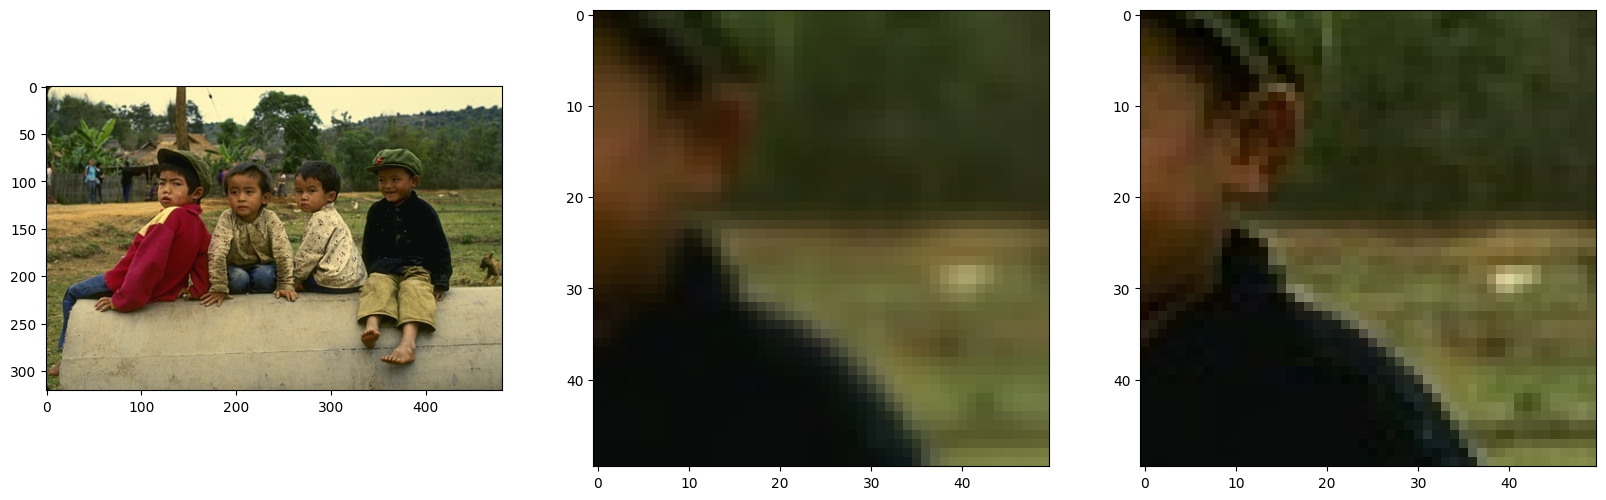

In [ ]:
test_img = all_images_path[1]
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].imshow( plt.imread(test_img)) # 원본 사진
# ---> lr , hr
test_lr, test_hr = get_hr_and_lr( test_img )
ax[1].imshow(test_lr )
ax[2].imshow(test_hr )

In [ ]:
# 참고) 주어진 데이터들을 하나의 데이터셋 만드는 과정!!!
# ==> 1. 이미지 같은 경우들은 폴더에서 생성하는 식!!! + 증강+전처리
# ==> 2. 데이터셋을 직접 만들어서 처리!!!!!

batch_size = 32 # GPU --> 이미지의 크기

# 1. 파일 경로 ---> 생성기 --> from_directory() --> 학습
# 2. 파일 경로 ---> tf에 Dataset 클래스!! --------> 학습 **
train_path = glob.glob("/content/images/train/*.jpg")
train_dataset = tf.data.Dataset.list_files(train_path )
train_dataset = train_dataset.map(get_hr_and_lr )
train_dataset = train_dataset.repeat(5)
train_dataset = train_dataset.batch(  batch_size )


# 지금 이 task는 val을 크게 신경안쓸려고 하는데,,
# 보통 하시다 보면 val도 같이 구성을 해야 함...
valid_path = glob.glob("/content/images/val/*.jpg")
valid_dataset = tf.data.Dataset.list_files(valid_path )
valid_dataset = valid_dataset.map(get_hr_and_lr )
valid_dataset = valid_dataset.repeat(1)
valid_dataset = valid_dataset.batch(  batch_size )

In [ ]:
### 모델을 만들어 보겠습니다...
### 모델을 생성하는 함수로 구현을 해보겠습니다.
#   - 입력 : 몇 층짜기 모델로 구성할지(숫자)
#            15 : Conv 15층
#                 ConvT 15층
#               ==> 총 30층의 네트워크를 생성!!!!
#   - 출력 : 위에 대한 구조에 맞는 모델
# 함수명을 REDNet

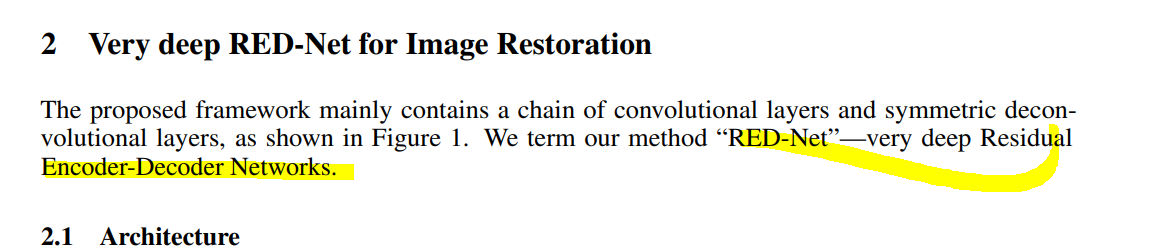

In [ ]:
# 고민 사항 중 하나!!!!
# 학습은 50* 50 * 3 ---> 50 * 50 * 3
# 적용   N * N  * 3 ---> N  * N  * 3
# ===> 학습은 50*50으로 하지만,,,
#      이 모델을 사용하는 입장에서는 다양한 크기에도 적용!!!
#      모델의 입력 구조에서 크기를 신경을 써야 함!!!
#      (50,50,3)---> ( None, None,3)

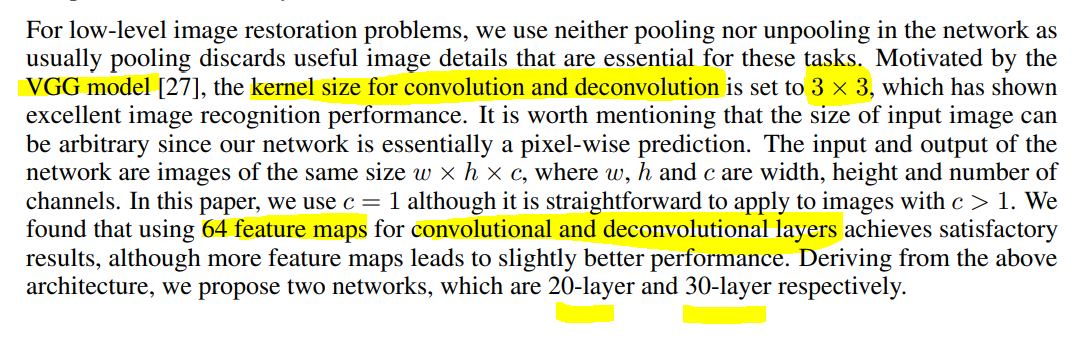

In [ ]:
def REDNet( num_layers):
    # 기본적인 변수들을 세팅 : 각기 레이어들을 담을 변수!!!!
    conv_layers = [] # 인코더를 담당하는 레이어들을 담을 변수
    deconv_layers = [] # 디코더를 담당하는 레이어들을 담을 변수
    residual_layers = [] # 중간 치팅용 잔차 레이어들을 담을 변수

    # ** 입력에 대해서는 크기와 상관없이 복원!!!
    # ==> 컬러이미지에 & 3채널 제약 조건
    # 1장 데이터 : 50 50 3 --> (None, None, 3)
    inputs = tf.keras.layers.Input( shape=(None,None,3))
    # ==> input_shape 파라미터로 초기 HL에 같이 밀려들어감..

    # 맨 처음 Conv에 대한 재료 리스트업
    conv_layers.append(
        # 나중에 복원을 위해서 채널을 3으로 유지...
        tf.keras.layers.Conv2D( filters=3,
                               kernel_size=3,
                                padding="same",
                                activation="relu")
    )

    # 중간 부분
    for i in range(num_layers - 1):
        conv_layers.append( tf.keras.layers.Conv2D(
            filters=64, kernel_size= 3,padding="same", activation="relu"
        ))
        deconv_layers.append( tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=3, padding="same",
            activation="relu"
        ))

    # 뒤쪽 convT 마지막
    deconv_layers.append( tf.keras.layers.Conv2DTranspose(
            filters=3, kernel_size=3, padding="same"))
    # ----===> 모델을 바느질을 하기 위한 재료들만 모아둔 것!!

    # 바느질 : in ~~ out
    # 1. 입력층과 1번 conv 인코더를 연결!!!!!
    x = conv_layers[0]( inputs )
    # 2. 안쪽의 인코더들을 연결을 해야 함!!!
    for i in range( num_layers -1 ):
        x = conv_layers[i+1](x)
        if i % 2 == 0 : # 짝수번째 conv 레이어는 deconv으로 연결 skip connectionj
            residual_layers.append(x)
    # 3. 디코더쪽을 연결!!!
    for i in range( num_layers -1):
        if i % 2 == 1: # 홀수뻔째 병합을 하려고 함.... add
            x = tf.keras.layers.Add()( [ x, residual_layers.pop()])
            x = tf.keras.layers.Activation("relu")(x)
        x = deconv_layers[i](x)
    # 4.맨 마지막의 de conv
    x = deconv_layers[-1](x)
    # ===> 만든 재료들을 바탕으로 바느질!!!!!!

    # 최종 모델을 조립!!!!
    model = tf.keras.Model(
        inputs = inputs,
        outputs = x
    )

    return model

In [ ]:
# 참고) kaggle이나 최신 연구들은 평가지표, loss 특이한 것들!!!!
#       ==> 플랫폼에서 만들지 않은 지표를 직접 만들어서 사용해야 함!!!!!
# 평가지표 : 실제 , 예측 ---> 원하는 지표 계산
def psnr_metric( y_true, y_pred):
    # psnr은 이미 대중적으로 사용하는 지표 : TF가 만들어 뒀음..
    # ++ 없으면 직접 수식으로 구현하면 됨!!!!!
    # ***** 원하는 수식 & 계산을 구현을 하면 됨!!!
    # ************************
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [ ]:
model = REDNet(15) # 모델을 함수를 통해서 생성,,,,
model.compile(
    # 참고 : 논문은 sgd를 사용을 했는데, 저는 살짝 수정하겠습니다...
    optimizer = tf.optimizers.Adam(0.0001),
    loss = "mse",
    metrics =[ psnr_metric ]
)

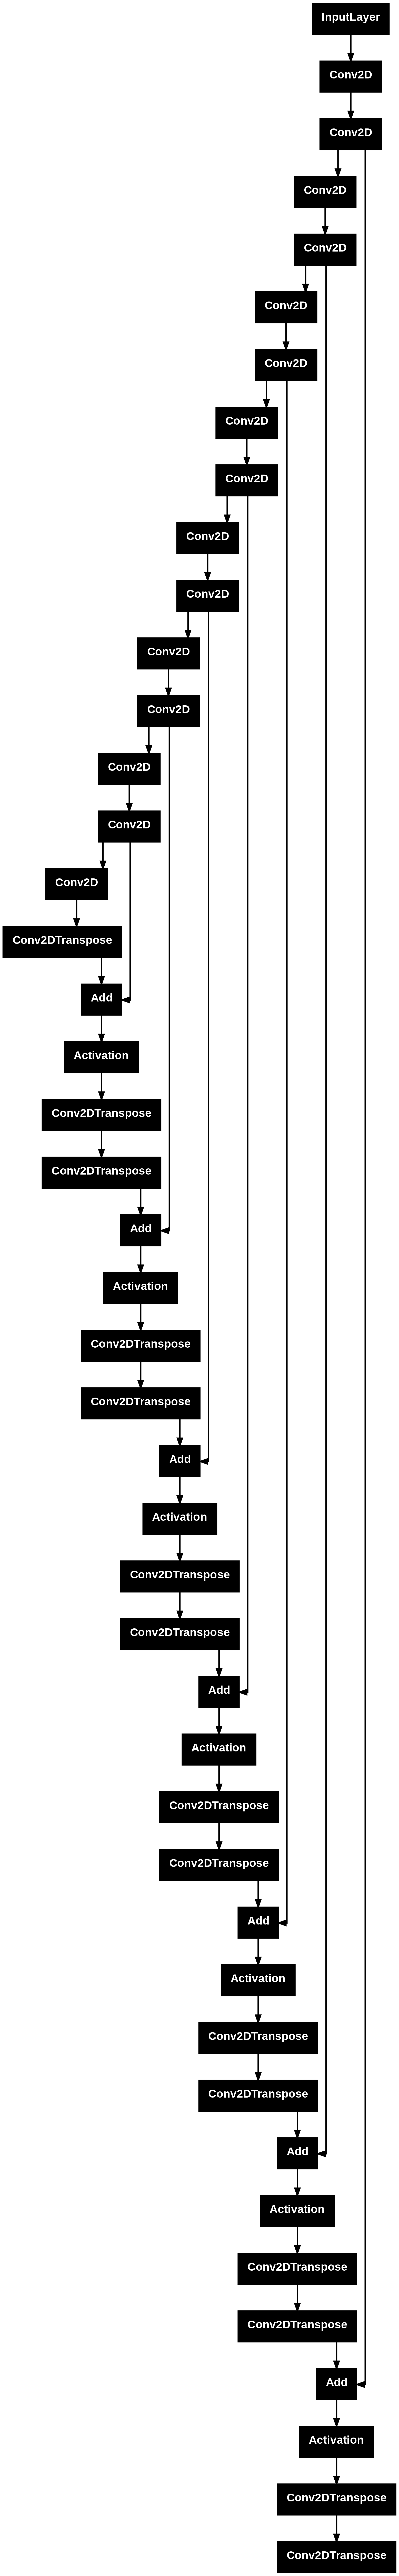

In [ ]:
tf.keras.utils.plot_model( model)

In [ ]:
# 실제 학습!!!
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data = valid_dataset
)
# 참고 : 생성,,,퀄리티
# ===> es에 대한 의미가 : 일반적으로 엄청나게 epochs
#      매번/ 10번/ 100번 : cp
# ===> 사후적으로 적용하면 어떤지 체크!!!!

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 333ms/step - loss: 0.1992 - psnr_metric: 8.6090 - val_loss: 0.0738 - val_psnr_metric: 12.8304
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0666 - psnr_metric: 13.0328 - val_loss: 0.0507 - val_psnr_metric: 14.1937
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0533 - psnr_metric: 13.8357 - val_loss: 0.0481 - val_psnr_metric: 13.8468
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0461 - psnr_metric: 14.5032 - val_loss: 0.0384 - val_psnr_metric: 15.0306
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0345 - psnr_metric: 15.7510 - val_loss: 0.0244 - val_psnr_metric: 17.3317
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0240 - psnr_metric: 17.3658 - val_loss: 0.0230 - val_psnr_metric: 17.4394
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0219 - psnr_metric: 18.0046 - val_loss: 0.0173 - val_psnr_metric: 19.0783
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/s

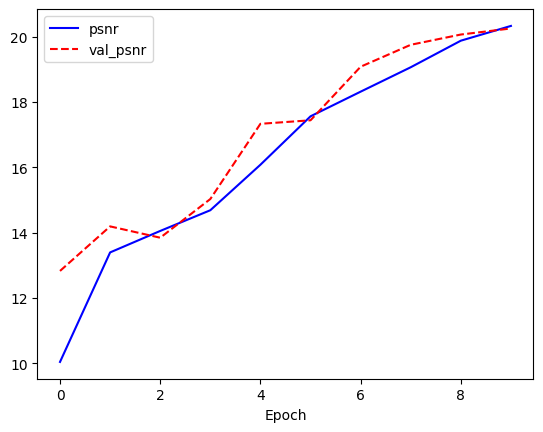

In [ ]:
# 학습 과정에 대한 그래프
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# 실제 test 이미지에 적용을 해보겠습니다!!!!

In [ ]:
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


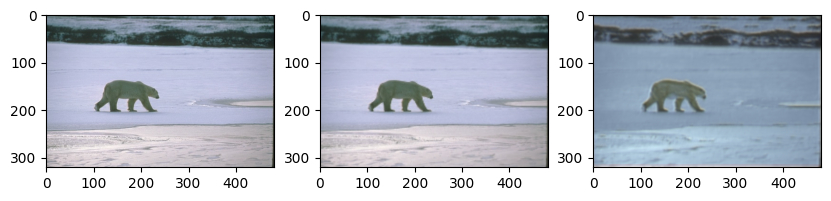

In [ ]:
# 모델의 설계를 입력은 (N,N,3)--> 채널만 3채널!!!!
img = tf.io.read_file("/content/images/test/100007.jpg" )
img = tf.image.decode_jpeg(img, channels=3)
# 비교할 모범 정답
hr = tf.image.convert_image_dtype(img, tf.float32)

# 테스트를 하려는 저해상도 이미지 생성
lr = tf.image.resize( hr, [hr.shape[0]//2, hr.shape[1]//2 ])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
# 1장에 대한 입력 ---> 모델에 넣기 위해서 차원을 올려야함!!!
predict_hr = model.predict( np.expand_dims(lr, axis=0))

plt.figure( figsize = (10, 30))
plt.subplot(3,3,1)
plt.imshow( hr) # 모범 정답

plt.subplot(3,3,2)
plt.imshow(lr) # 입력을 넣은 저해상도

plt.subplot(3,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))

In [ ]:
# epoch를 늘려가면서 해보면 됨!!!!!!!
# ==> 잘 되는 이미지들과 안 되는 이미지들을 분석!!!
#     모델의 특성!!!!!

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


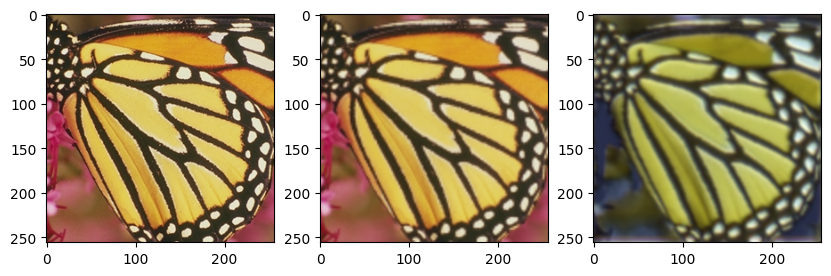

In [ ]:
# 논문상에 있는 나비 그림으로 테스트해보자!!!
test_sample_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(test_sample_path)
# 비교할 모범 정답
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

# 테스트를 하려는 저해상도 이미지 생성
lr = tf.image.resize( hr, [hr.shape[0]//2, hr.shape[1]//2 ])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
# 1장에 대한 입력 ---> 모델에 넣기 위해서 차원을 올려야함!!!
predict_hr = model.predict( np.expand_dims(lr, axis=0))

plt.figure( figsize = (10, 30))
plt.subplot(3,3,1)
plt.imshow( hr) # 모범 정답

plt.subplot(3,3,2)
plt.imshow(lr) # 입력을 넣은 저해상도

plt.subplot(3,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))

In [ ]:
# 실제 학습!!!
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data = valid_dataset
)
# 참고 : 생성,,,퀄리티
# ===> es에 대한 의미가 : 일반적으로 엄청나게 epochs
#      매번/ 10번/ 100번 : cp
# ===> 사후적으로 적용하면 어떤지 체크!!!!

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0123 - psnr_metric: 20.6161 - val_loss: 0.0116 - val_psnr_metric: 20.7856
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0133 - psnr_metric: 20.2497 - val_loss: 0.0099 - val_psnr_metric: 21.6089
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0114 - psnr_metric: 21.0412 - val_loss: 0.0091 - val_psnr_metric: 21.9677
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.0101 - psnr_metric: 21.7934 - val_loss: 0.0091 - val_psnr_metric: 22.2691
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0095 - psnr_metric: 22.0461 - val_loss: 0.0081 - val_psnr_metric: 22.7575
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.0089 - psnr_metric: 22.0833 - val_loss: 0.0071 - val_psnr_metric: 23.1082
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0086 - psnr_metric: 22.3975 - val_loss: 0.0076 - val_psnr_metric: 22.9417
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


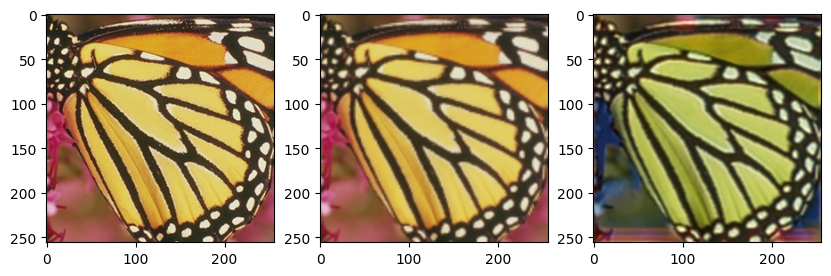

In [ ]:
# 논문상에 있는 나비 그림으로 테스트해보자!!!
test_sample_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(test_sample_path)
# 비교할 모범 정답
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

# 테스트를 하려는 저해상도 이미지 생성
lr = tf.image.resize( hr, [hr.shape[0]//2, hr.shape[1]//2 ])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
# 1장에 대한 입력 ---> 모델에 넣기 위해서 차원을 올려야함!!!
predict_hr = model.predict( np.expand_dims(lr, axis=0))

plt.figure( figsize = (10, 30))
plt.subplot(3,3,1)
plt.imshow( hr) # 모범 정답

plt.subplot(3,3,2)
plt.imshow(lr) # 입력을 넣은 저해상도

plt.subplot(3,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))

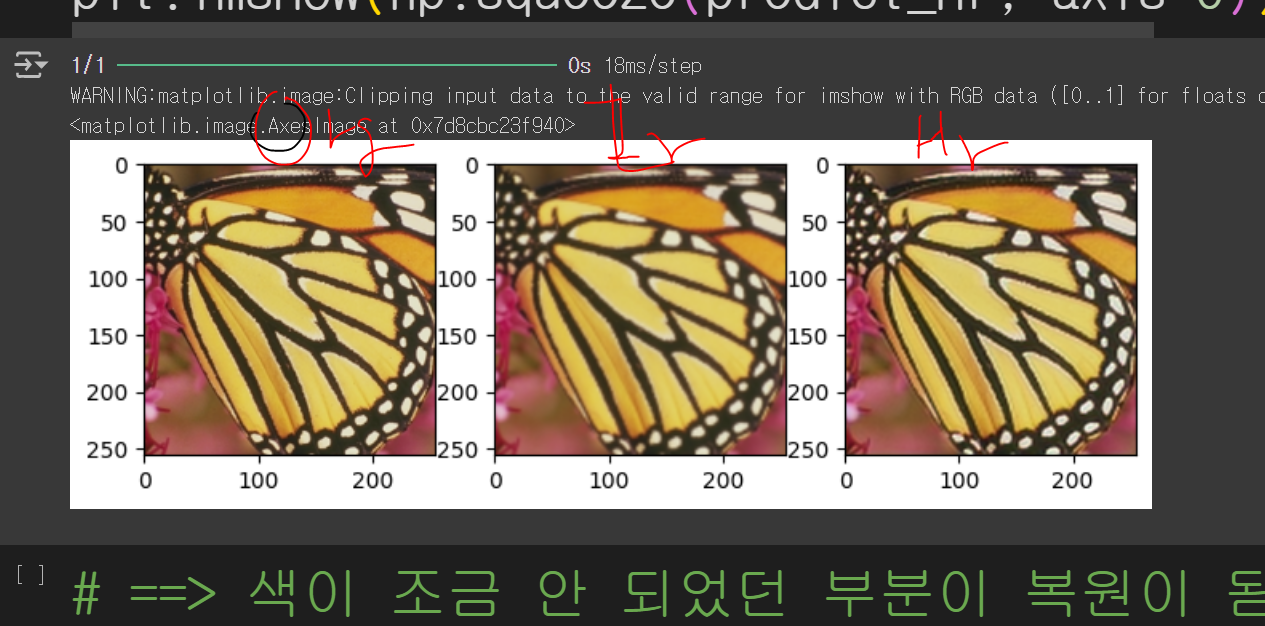

In [ ]:
# 정리
# 1. 내가 하고자 하는 일에 대해서 함수로 생각!!!
#    in // out  : 전통적인 task이외에 다양하게 시도!!!!!
#    + 여러 비정형을 가지고 할 수 있는 도구!!!!
#    ==> 내가 원하는 in.out에 대해서 어떻게 네트워크화를 할 것!!!!
#    ==> 숫자만 바라보고 진행을 하는 것!!! (어떻게 수치화!!!!)

# 2. 할 모델의 구조들을 단순 적층 구조가 아니라..
#    블럭 단위로 조립 & 여러 모듈과 연결!!!!!!
#    ==> 클래스,,,,,,+ 블럭단위!!!!!

# 3. 새로운 지표/ loss ==> 직접 함수로 만들어서 할 수 있다!!!!!!